# Using the COGITATE iEEG data 
In this notebook, we will demonstrate how to perform simple basic operation on the iEEG data of the COGITATE consortium. 
This includes applying our preprocessing pipelines to generate epoched data, as well as simple analysis such as onset 
responsiveness and decoding. 


In [4]:
# Setting all modules:
from pathlib import Path
import mne
from mne_bids import BIDSPath, read_raw_bids
import numpy as np
import matplotlib.pyplot as plt

from PreprocessingMaster import preprocessing
from OnsetResponsiveness import onset_responsiveness
from Decoding import decoding

## Downloading the BIDS converted data
The first step consists in downloading the data using rest API calls. The interface with XNAT enables filtering of participants,
enabling you to select subjects according to various criterion such as age, gender and various other demographic information. 
For the current example we will simply show you how to download XXXX

In [2]:
bids_root = "C://Users//alexander.lepauvre//Documents//GitHub//iEEG-data-release//bids"

The data follow the bids conventions. The mne-bids functions can therefore be used to generate path to the data and so on. 
So for example, if we wish to load the raw data, this can be achieved like so:

In [5]:
bids_path = BIDSPath(root=bids_root, subject='SF102',
                     session='V1',
                     datatype='ieeg',
                     task='Dur')
# Loading the data under the term broadband, as it is what they are as long as no further
# filtering was employed
raw = read_raw_bids(bids_path=bids_path, verbose=True)

Extracting parameters from C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\bids\sub-SF102\ses-V1\ieeg\sub-SF102_ses-V1_task-Dur_ieeg.vhdr...
Setting channel info structure...
Reading events from C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\bids\sub-SF102\ses-V1\ieeg\sub-SF102_ses-V1_task-Dur_events.tsv.
Reading channel info from C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\bids\sub-SF102\ses-V1\ieeg\sub-SF102_ses-V1_task-Dur_channels.tsv.


C:\Users\alexander.lepauvre\AppData\Local\Temp\ipykernel_4640\2058158197.py:7: RuntimeWarning: participants.tsv file not found for C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\bids\sub-SF102\ses-V1\ieeg\sub-SF102_ses-V1_task-Dur_ieeg.vhdr
  raw = read_raw_bids(bids_path=bids_path, verbose=True)


Effective window size : 1.000 (s)


C:\Users\alexander.lepauvre\AppData\Local\Temp\ipykernel_4640\4108630121.py:1: RuntimeWarning: in version 1.5, the default behavior of Spectrum.plot() will change so that bad channels will be shown by default. To keep the old default behavior (and silence this warning), explicitly pass `picks='data', exclude='bads'`.
  raw.compute_psd().plot()
C:\Users\alexander.lepauvre\AppData\Local\Temp\ipykernel_4640\4108630121.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd().plot()
C:\Users\alexander.lepauvre\AppData\Local\Temp\ipykernel_4640\4108630121.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd().plot()
C:\Users\alexander.lepauvre\.conda\envs\mne\Lib\site-packages\mne\viz\utils.py:151: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


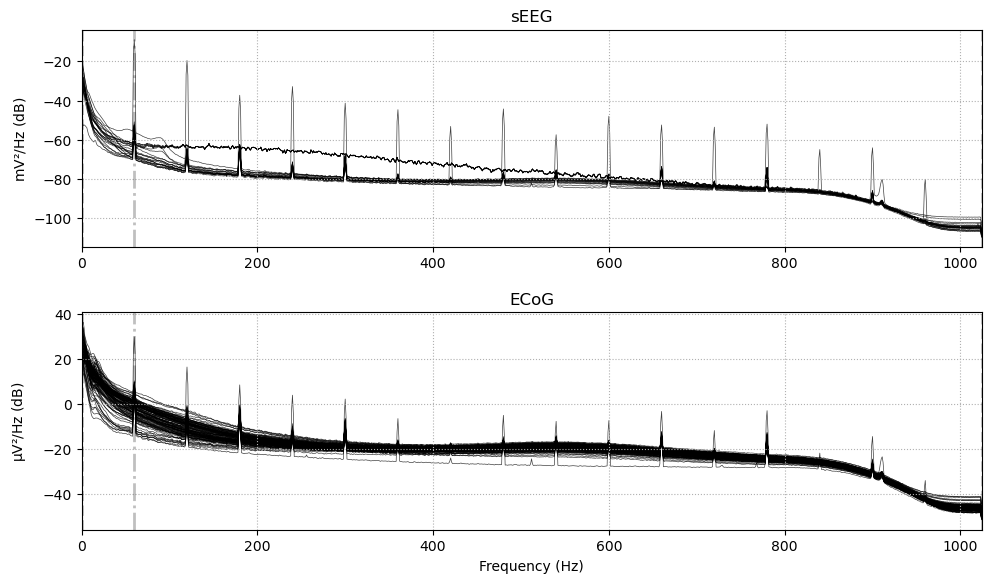

In [8]:
raw.compute_psd().plot(picks='data', exclude='bads')

## Running the preprocessing
The BIDS downloaded data can then be preprocessed. In this code, we provide a preprocessing pipeline which applies the following
steps:
- Removal of bad channels 
- Notch filtering to remove line noise (60Hz)
- Re-referencing using Laplace scheme
- High gamma computations (70-150Hz)
- ERP computations (0-30Hz)
- Epoching
(See here for more details)

This preprocessing pipeline can be called using the provided function called preprocessing. This function requires 3 inputs:
- config_file: a json file specifying all the details of the steps to perform
- subjects_list: a list of the name of all the subjects on whom to apply the pipeline
- bids_root: path to the bids folder on the local drive.

The command below will apply the preprocessing pipeline as specified in the default config file of this repository, which follow
the specification of this paper. The pipeline is highly configurable and can be adjusted by specifying different options,
different order of steps and so on. If you wish to change the pipeline, we recommand you create a copy of the existing one
and rename it according to your needs.

In [ ]:
subjects_list = ["SF102"]
config_file = "PreprocessingParameters_task-Duration_release.json"
preprocessing(config_file, subjects_list, bids_root)

### Visualizing the preprocessed data
The final output of the preprocessing pipeline are the epoched data. The naming conventions of the folders follow the BIDS conventions
You can therefore load the data as follows, and plot a single channel using mne functionalities

In [11]:
subject = 'SF102'
channel = 'LO1'
example_epochs_path = Path(bids_root, 'derivatives', 'preprocessing',
                           'sub-' + subject, 'ses-' + "V1", 'ieeg',
                           "epoching", 'high_gamma',
                           "sub-{}_ses-{}_task-{}_desc-epoching_{}-epo.fif".format(subject,
                                                                                   "V1", "Dur",
                                                                                   "ieeg"))

epochs = mne.read_epochs(example_epochs_path, preload=True)
mne.viz.plot_epochs_image(epochs, picks=channel, 
                          show=False, units=dict(ecog="HGP (norm.)", seeg="HGP (norm.)"),
                          scalings=dict(ecog=1, seeg=1),
                          evoked=True, cmap="RdYlBu_r")

Reading C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\bids\derivatives\preprocessing\sub-SF102\ses-V1\ieeg\epoching\high_gamma\sub-SF102_ses-V1_task-Dur_desc-epoching_ieeg-epo.fif ...
    Found the data of interest:
        t =    -750.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
1440 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1440 matching events found
No baseline correction applied
0 projection items activated


[<Figure size 640x480 with 4 Axes>]

Notice that the figure above looks odd, with some activation in the baseline. That is because we have data that are epochs relative to both the onset and the offset of the stimuli for different analyses. For most purpose, we would need to select only the epochs locked to stimulus onset. This can be achieved by selecting the epochs by conditions, like so:

Not setting metadata
720 matching events found
No baseline correction applied
0 projection items activated


[<Figure size 640x480 with 4 Axes>]

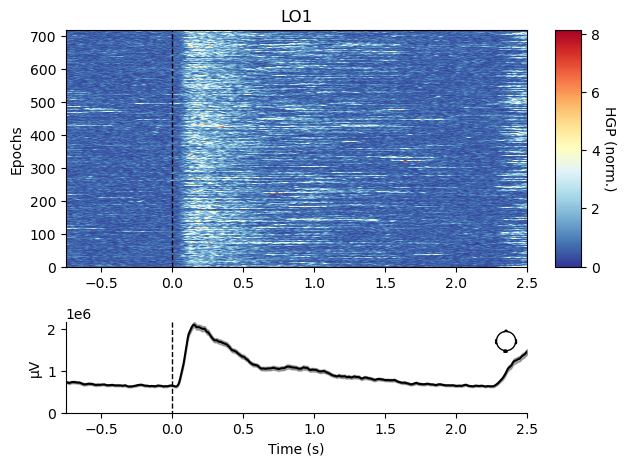

In [13]:
onset_locked_epochs = epochs['stimulus onset']
mne.viz.plot_epochs_image(onset_locked_epochs, picks=channel, 
                          show=False, units=dict(ecog="HGP (norm.)", seeg="HGP (norm.)"),
                          scalings=dict(ecog=1, seeg=1),
                          evoked=True, cmap="RdYlBu_r")

In general, if you wish to extract specific conditions, this data are equipped with forward slash separated strings, enabling you to select any condition by passing the according string or list of strings. Consult the documentation found XXX to find all the conditions
that can be accessed from the data.

Not setting metadata
320 matching events found
No baseline correction applied
0 projection items activated


[<Figure size 640x480 with 4 Axes>]

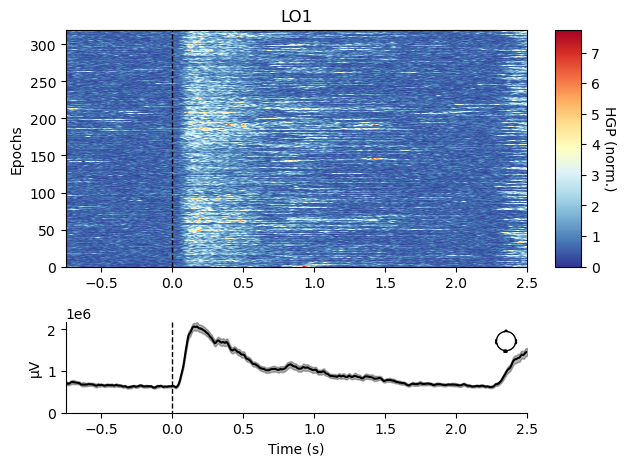

In [14]:
task_relevant_epochs = epochs['stimulus onset/Relevant non-target']
mne.viz.plot_epochs_image(task_relevant_epochs, picks=channel, 
                          show=False, units=dict(ecog="HGP (norm.)", seeg="HGP (norm.)"),
                          scalings=dict(ecog=1, seeg=1),
                          evoked=True, cmap="RdYlBu_r")

Not setting metadata
26 matching events found
No baseline correction applied
0 projection items activated


[<Figure size 640x480 with 4 Axes>]

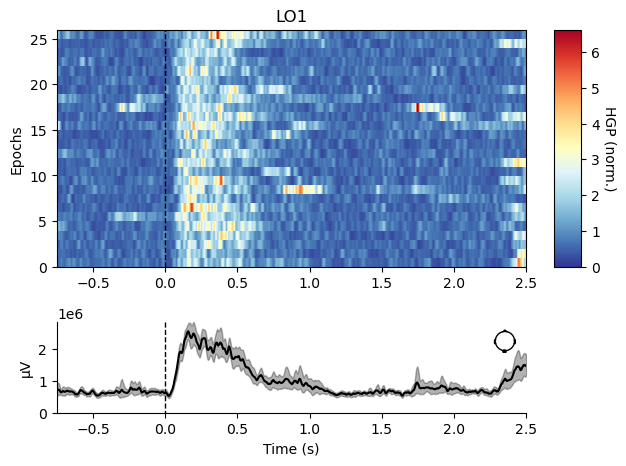

In [15]:
task_relevant_face_short_epochs = epochs['stimulus onset/Relevant non-target/face/500ms']
mne.viz.plot_epochs_image(task_relevant_face_short_epochs, picks=channel, 
                          show=False, units=dict(ecog="HGP (norm.)", seeg="HGP (norm.)"),
                          scalings=dict(ecog=1, seeg=1),
                          evoked=True, cmap="RdYlBu_r")

## Onset responsiveness
Now that the data were preprocessed, we can apply the onset responsiveness analysis, which consists in comparing single channel activation before and after visual stimuli onsets, using a simple paired t-test. This enables determining which 
are the channels which are responsive to our task in general. 

To do so, we first extract the trials which are locked on the onset and on the offset and further removing the target trials, which required a response from the participants. We will then extract pre and post-stimulus presentation segments. The data within each segment will be aggregated by computing the area under the curve (np.trapz) which will then be statistically compared using a paired t-test.

In [10]:
# Select the trials of interest:
onset_responsiveness_data =  epochs[["stimulus onset/Irrelevant", "stimulus onset/Relevant non-target"]]
# Crop the data:
prestim_data = np.squeeze(onset_locked_epochs.copy().crop(tmin=-0.3, tmax=0).get_data(picks='LO1'))
poststim_data = np.squeeze(onset_locked_epochs.copy().crop(tmin=0.05, tmax=0.350).get_data(picks='LO1'))
# Compute the AUC:
prestim_auc = np.trapz(ch_prestim, axis=1)
poststim_auc = np.trapz(ch_poststim, axis=1)
# Perform a two sided paired t-test:
results = scipy.stats.ttest_rel(prestim_auc, poststim_auc, axis=0, nan_policy='propagate',
                                alternative='two-sided')
print(results)

NameError: name 'epochs' is not defined

### Onset responsiveness pipeline
The above example was applied to a single channel from a single participant. We further provide pipelines that enable the 
computation of onset responsiveness on all channels and subjects. As in the case of the preprocessing pipeline, this can
be achieved by calling the function onset_responsiveness which takes 3 mandatory inputs:
- config_file: a json file specifying the details of the analysis, such as the trials on which to apply the pipeline, pre and post stimuli time windows, metric to use...
- subjects_list: a list of the name of all the subjects on whom to apply the pipeline
- bids_root: path to the bids folder on the local drive.
Just as in the case of the pre-processing, the config files are highly configurable with many additional options. Make sure to visit XXX to investigate these options and how to specify them.

This function further takes two additional inputs:
- plot_single_channels: boolean flag to plot single electrodes or not
- plot_only_responsive: boolean flag to plot only those channels that were found to have differences in activation compared to baseline. 

Importantly, single channels plotting can take a long time. 

In [16]:
subjects_list = ["SF102"]
config_file = "OnsetResponsiveness_task-Duration_release.json"
results = onset_responsiveness(config_file, subjects_list, bids_root,
                                   plot_single_channels=False, plot_only_responsive=False)

----------------------------------------
Welcome to Onset Responsiveness!
The onset responsive channels of the following subjects will be determined: 
['SF102']
Using the config file:
OnsetResponsiveness_task-Duration_release.json
If you have the plotting options on, it will take some time!
----------------------------------------
Onset responsiveness SF102 with config file OnsetResponsiveness_task-Duration_release.json
Reading C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\bids\derivatives\preprocessing\sub-SF102\ses-V1\ieeg\epoching\high_gamma\sub-SF102_ses-V1_task-Dur_desc-epoching_ieeg-epo.fif ...
    Found the data of interest:
        t =    -750.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
1440 matching events found
No baseline correction applied
0 projection items activated


### Investigate the results
Now that we have ran the onset responsiveness analysis, we can provide some summary statistics for the 
data. 

----------------------------------------
46 out of 92 (50.0%) were found to be onset responsive!


<Axes: xlabel='reject'>

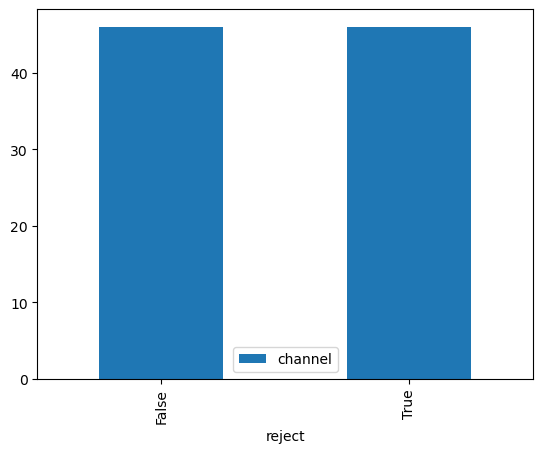

In [17]:
# Channels counts:
channels_counts = results.groupby("reject").count().reset_index()[["reject", "channel"]]
# Print the counts:
print('-'*40)
print("{} out of {} ({}%) were found to be onset responsive!".format(
    channels_counts.loc[channels_counts['reject'] == True, 'channel'].item(), len(results),
    channels_counts.loc[channels_counts['reject'] == True, 'channel'].item() / len(results) * 100))
# Plot the results as a bar graph:
channels_counts.plot.bar(x="reject", y="channel")


We can also further investigate the results by looking at each subject separately:

  subject  reject  channel
0   SF102   False       46
1   SF102    True       46


<Axes: >

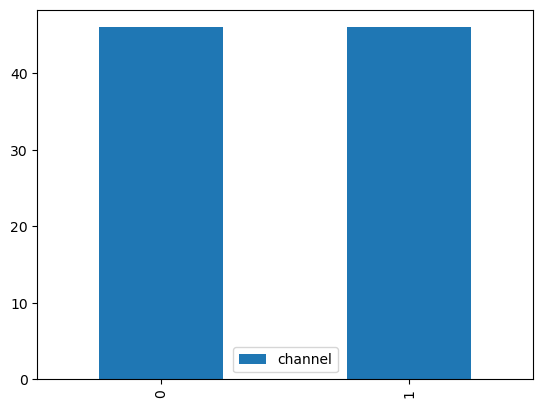

In [19]:
subjects_channels_counts = results.groupby(["subject", "reject"]).count().reset_index()[["subject", "reject", "channel"]]
# Print the counts:
print(subjects_channels_counts)
# Plot the results as a bar graph:
subjects_channels_counts.plot.bar()

### Plotting responsive channels on the brain surface
One important sanity check is to make sure that the localization of the effects make sense. As 
the task in the COGITATE was visual, one would expect to find a lot of onset responsive electrodes
over the posterior cortex. To check whether that is the case, we will extract only the onset responsive
electrodes that we hve identified above and we will plot that on the pial surface. 

This step require MNE setup to have been performed as to allow 3D rendering. Consult the MNE webpage: XXX

In [ ]:
# Extract the onset responsive electrodes:
onset_responsive_results = results.loc[results["reject"] == True]
# Get these channels localization in MNI space:
mni_montage = get_channels_mni_coordinates(onset_responsive_results["channel"].to_list(), 
                                                       bids_path, Path(bids_path.root, 'derivatives', 'fs'))

# We can now go ahead and plot the dig montage on the brain:
fig = plot_alignment(
    info=None,
    trans="fsaverage",
    subject="fsaverage",
    subjects_dir=subjects_dir,
    surfaces=["pial"],
    coord_frame="head",
    sensor_colors=(1.0, 1.0, 1.0, 0.5),
)
mne.viz.set_3d_view(fig, azimuth=0, elevation=70, focalpoint="auto", distance="auto")

xy, im = snapshot_brain_montage(fig, raw.info)


Additionally, not only do we expect more channels to be responsive in posterior regions, we also expect the effects to be stronger. To vizualize this, you can plot the effect sizes of the onset
responsiveness on the brain.

In [ ]:
effect_sizes = onset_responsive_results["f_size"].to_list()
rgba = colormaps.get_cmap("RdYlBu_r")
sensor_colors = np.array(gamma_power_at_15s.map(rgba).tolist(), float)
fig = plot_alignment(
    raw.info,
    trans="fsaverage",
    subject="fsaverage",
    subjects_dir=subjects_dir,
    surfaces=["pial"],
    coord_frame="head",
    sensor_colors=sensor_colors,
)

mne.viz.set_3d_view(fig, azimuth=0, elevation=70, focalpoint="auto", distance="auto")

xy, im = snapshot_brain_montage(fig, raw.info)

## Decoding
In addition to investigate the univariate responses of every single channel, we can also performed a multivariate analysis, investigating the presence of representation of particular contrasts of interests across the electrodes in our sample. In the current example, we will
use support vector machine to decode faces vs. objects across all electrodes within each single
subject. Once again, we will use a function taking three input: a config file, a list of subjects
and the bids root:

In [3]:
subjects_list = ["SF102"]
config_file = "Decoding_task-Duration_release.json"
scores = decoding(config_file, subjects_list, bids_root)

----------------------------------------
Welcome to Decoding!
The onset responsive channels of the following subjects will be determined: 
['SF102']
Using the config file:
Decoding_task-Duration_release.json
----------------------------------------
Decoding SF102 with config file Decoding_task-Duration_release.json
Reading C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\bids\derivatives\preprocessing\sub-SF102\ses-V1\ieeg\epoching\high_gamma\sub-SF102_ses-V1_task-Dur_desc-epoching_ieeg-epo.fif ...
    Found the data of interest:
        t =    -750.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
1440 matching events found
No baseline correction applied
0 projection items activated
Decoding category with 5 folds stratified cross validation:


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   13.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.6s finished


We can now plot the results averaged across participants

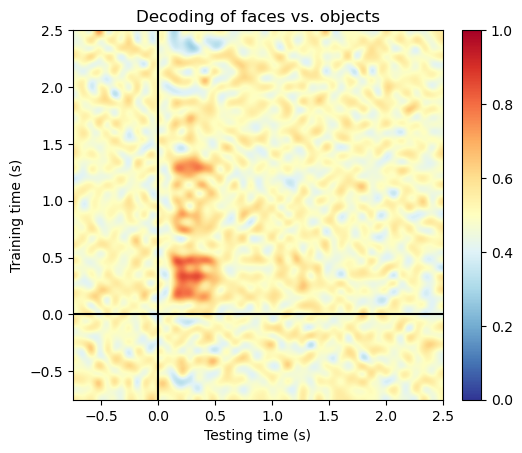

In [9]:
# Plot the results:
fig, ax = plt.subplots()
# Plot matrix with transparency:
im = ax.imshow(np.mean(scores, axis=0), cmap="RdYlBu_r",
               extent=[epochs.times[0], epochs.times[-1], epochs.times[0], epochs.times[-1]],
               origin="lower",  # aspect="equal",
               interpolation="lanczos", vmin=0, vmax=1)
# Add the axis labels and so on:
ax.set_xlim([epochs.times[0], epochs.times[-1]])
ax.set_ylim([epochs.times[0], epochs.times[-1]])
ax.set_xlabel("Testing time (s)")
ax.set_ylabel("Training time (s)")
ax.set_title("Decoding of {}".format("faces vs. objects"))
ax.axvline(0, color='k')
ax.axhline(0, color='k')
fig.colorbar(im, fraction=0.046, pad=0.04)

We can also plot the diagonal, i.e. the time resolved decoding

Text(0, 0.5, 'roc_auc')

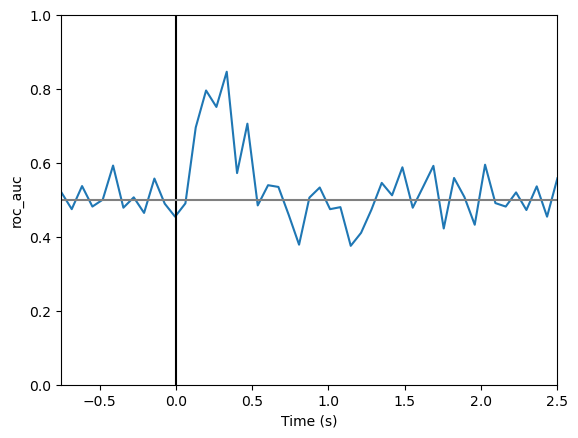

In [26]:
    fig, ax = plt.subplots()
    times = np.linspace(epochs.times[0], epochs.times[-1], scores[0].shape[0])
    ax.plot(times, np.diag(np.mean(scores, axis=0)))
    ax.set_xlim([epochs.times[0], epochs.times[-1]])
    ax.set_ylim([0, 1])
    ax.axvline(0, color='k')
    ax.axhline(0.5, color=[0.5, 0.5, 0.5])
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("roc_auc")